In [100]:
#Importing libraries
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
import random
import shutil
from PIL import Image

In [119]:
#Splitting the dataset into train and test folders. Please create test and train dir in the given path before running this.

def delete_contents(folder): # function to delete the files in a dir
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def get_files_from_folder(path): #Returns all the files and folders in a given path.

    files = os.listdir(path)
    return np.asarray(files)

def main(path_to_data, path_to_test_data, path_to_train_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))
    train_counter = np.round(data_counter_per_class * train_ratio)

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_test_data):
            os.makedirs(path_to_test_data)
        if not os.path.exists(path_to_train_data):
            os.makedirs(path_to_train_data)
        files = get_files_from_folder(path_to_original)
        random.shuffle(files)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_test_data, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
        files = get_files_from_folder(path_to_original)
        random.shuffle(files)
        for j in range(int(train_counter[i])):
            dst = os.path.join(path_to_train_data, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
if __name__ == "__main__":
    delete_contents('./train')
    delete_contents('./test')
    main('./Images_face95','./test','./train',0.7)

In [102]:
#Path for the training images

Path = './train/'
files = os.listdir(Path)
files.sort()

In [103]:
#Converting each image to Grayscale and appending the data to images

images = []

for name in files:
    temp = cv2.imread('./train/'+name)
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp, (100,100), interpolation = cv2.INTER_AREA)
    images.append(temp.flatten())
        
# total number of images considered : 360 - 5 of each person
# images converted to grayscale of size : (100,100)

# images : rows - 360
#          columns - 100*100 = 10000
# images.shape : (360,10000)

# temp.shape : (100, 100)

In [104]:
# Calculating the mean of images

images = np.array(images)
image_mean = images.mean(axis = 0)
images = images - image_mean
images = images.T
# transpose of images taken to find eigen vectors of matrix A'A

# image_mean.shape : (100000,)
# images.shape : (10000, 360)

In [105]:
#SVD function
#u is the basis of eigen faces

u,s,v = np.linalg.svd(images, full_matrices=False)

# u.shape : (10000, 360)
# There are 360 eigen faces currently

(1008,)


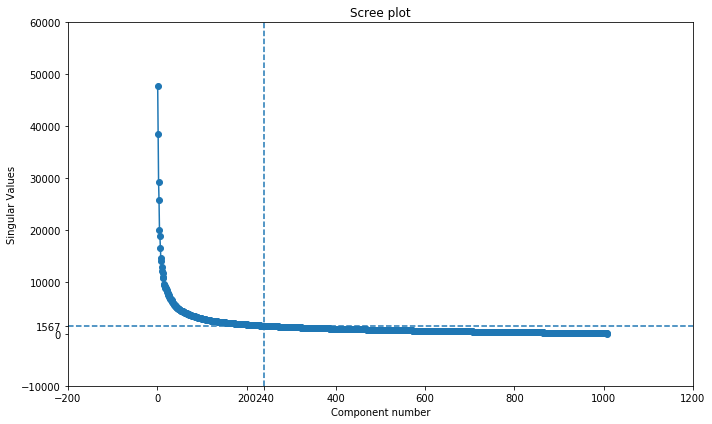

In [106]:
print(s.shape)
x1 = range(1,images.shape[1]+1)
y1 = s
#Plot a line graph
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(x1, y1, marker='o')
ax1.axhline(y=s[240], xmin=0, xmax=images.shape[1], ls='--')
ax1.axvline(x=240, ymin=0, ymax=s[240], ls='--')
x_ticks = np.append(ax1.get_xticks(), 240)
y_ticks = np.append(ax1.get_yticks(), s[240])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_title("Scree plot")
ax1.set(xlabel="Component number",ylabel="Singular Values")
fig.tight_layout()
plt.show()

In [107]:
#dropping the unwanted columns in U matrix
u = u[:,:240]

In [108]:
#Dot product of all the images and U matrix to find the projection co-efficients

dot_train = np.empty(shape = (u.shape[1], images.shape[1]),  dtype=np.int8) #360 by 360
temp = np.empty(shape = (1, u.shape[1]),  dtype=np.int8) #1 by 360

# dot_train.shape : (120, 720)
# temp.shape : (1, 120)
# images.shape : (10000, 720)

for i in range(images.shape[1]):    # i from 0 to 360
    for c in range(u.shape[1]):    # c from 0 to 360
        temp[0,c] = np.sum(images[:,i] * u[:,c])
        
    dot_train[:, i] = temp[:]

In [109]:
# REPEAT THE EXECUTION OF CODE BELOW FOR NEW INPUT

In [110]:
#Path for the training images

Path = './test/'
tfiles = os.listdir(Path)
tfiles.sort()

In [111]:
test_images = []

for name in tfiles:
    temp = cv2.imread('./test/'+name)
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp, (100,100), interpolation = cv2.INTER_AREA)
    test_images.append(temp.flatten())

In [112]:
#Substracting mean
test_images = np.array(test_images)
test_images = test_images - image_mean
test_images = test_images.T

In [114]:
#Dot product of test image and U matrix

dot_test = np.empty(shape = (u.shape[1], test_images.shape[1]), dtype=np.int8)
temp = np.empty(shape = (1, u.shape[1]),  dtype=np.int8)
    
for i in range(test_images.shape[1]):    # i from 0 to 432
    for c in range(u.shape[1]):    # c from 0 to 240
        temp[0,c] = np.sum(test_images[:,i] * u[:,c])
    dot_test[:, i] = temp[:]

In [115]:
# calculating the variation between input image and test images
answer = np.empty(shape=(dot_train.shape[1],dot_test.shape[1]))
for i in range(dot_test.shape[1]):
    sub = np.empty(shape = (u.shape[1], dot_train.shape[1]), dtype=np.int8)
    for col in range(dot_train.shape[1]):
        sub[:,col] = dot_train[:,col] - dot_test[:,i]
    for c in range(sub.shape[1]):    
        answer[c,i] = np.linalg.norm(sub[:,c])

In [116]:
def min_index(temp):
    m = 0
    for i in range(len(temp)):
        if temp[i]<temp[m]:
            m = i
    return m

In [117]:
# FACE RECOGNITION
temp_ans = np.empty(shape=(answer.shape[1],),dtype=int)
temp = np.empty(shape=(answer.shape[0],))
for i in range(0,answer.shape[1]):
    temp = answer[:,i]
    temp_ans[i] = min_index(temp)

In [118]:
right = 0
total = test_images.shape[1]
for i in range(temp_ans.shape[0]):
    if tfiles[i].split(".")[0] == files[temp_ans[i]].split(".")[0]:
        right+=1
eff = (right/total)*100
print("Efficiency: ",eff,"%")

Efficiency:  90.27777777777779 %
